# Homework of Online Convex Optimization

Joseph Vilamarest and Pierre Gaillard

The objective of this homework is to implement from scratch several algorithms from the class to predict daily electricity load in France.

In [510]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Historical data used to train the models
data_train = pd.read_csv("data_train.csv") 
n0 = len(data_train)

# Test data to be predicted day by day by the model
data_test = pd.read_csv("data_test.csv")  
n1 = len(data_test)

data_train.head()

Unnamed: 0        Date          Load        Load.1        Load.7  \
0           1  2012-01-01  51491.500000  51491.500000  51491.500000   
1           2  2012-01-02  60683.645833  51491.500000  60683.645833   
2           3  2012-01-03  67762.104167  60683.645833  67762.104167   
3           4  2012-01-04  68029.229167  67762.104167  68029.229167   
4           5  2012-01-05  69157.395833  68029.229167  69157.395833   

        Temp   Temp_s95   Temp_s99  Temp_s95_min  Temp_s95_max  ...       toy  \
0  11.469339  11.531273  11.398842     11.127697     12.162831  ...  0.001338   
1   8.136864   9.514619  10.817107      7.712891     11.110701  ...  0.004070   
2   8.538243   8.038437   9.633405      6.949912      9.187603  ...  0.006803   
3   8.251058   8.510991   9.266142      8.099900      8.932965  ...  0.009535   
4   9.278617   8.869048   9.056359      8.205341      9.631501  ...  0.012267   

    WeekDays  BH  Year  Month  DLS  Summer_break  Christmas_break  \
0     Sunday   1  2012      1    1             0               20   
1     Monday   0  2012      1    1             0               20   
2    Tuesday   0  2012      1    1             0                0   
3  Wednesday   0  2012      1    1             0                0   
4   Thursday   0  2012      1    1             0                0   

   GovernmentResponseIndex   Time  
0                      0.0  15340  
1                      0.0  15341  
2                      0.0  15342  
3                      0.0  15343  
4                      0.0  15344  

[5 rows x 22 columns]

In [512]:
# Convert Date column to datetime if not already
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_test['Date'] = pd.to_datetime(data_test['Date'])

The goal is to use combine several models that were trained during the train period (2012-2019) before combining them online after Jan 1st 2020 to perform as well as the best combination.


## Load (or train) expert forecasts

Utilize historical data to train machine learning or statistical models (like GAMs, random forests, gradient boosting,...) to generate predictions for the test period.

Here, we load the forecasts directly.

In [515]:
targets = data_test['Load']
experts = pd.read_csv("experts_all.csv",index_col=0)
experts.head()
T, d = np.shape(experts)


### Question 1

Plot the data from 2012 to 2021 by showing the electricity load that was used to train the experts, the target to be predicted sequentially and the expert predictions.


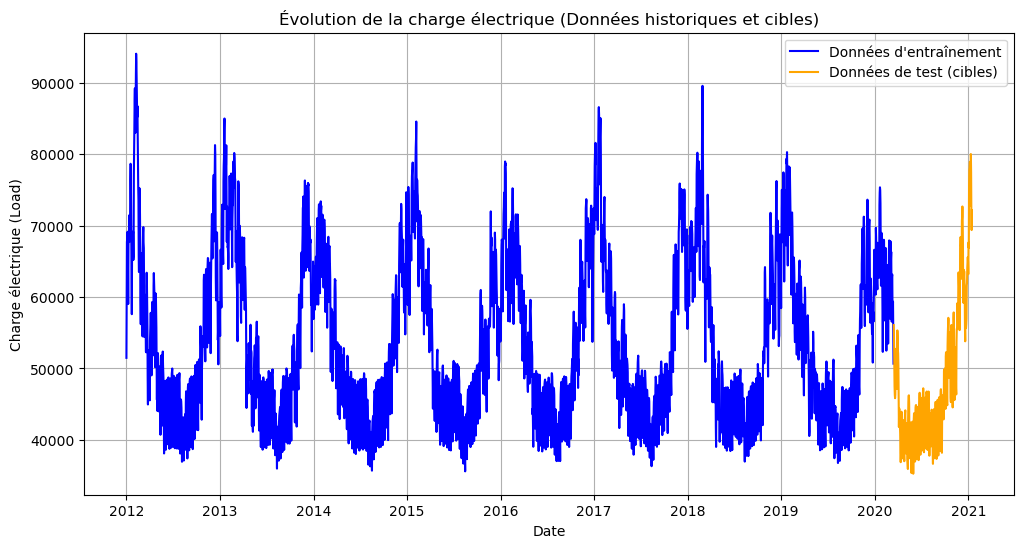

In [518]:
# Tracer les données de charge électrique
plt.figure(figsize=(12, 6))

# Tracer les données d'entraînement
plt.plot(data_train['Date'], data_train['Load'], label='Données d\'entraînement', color='blue')

# Tracer les données de test (les cibles à prédire)
plt.plot(data_test['Date'], data_test['Load'], label='Données de test (cibles)', color='orange')

# Ajouter des étiquettes et des légendes
plt.xlabel('Date')
plt.ylabel('Charge électrique (Load)')
plt.title('Évolution de la charge électrique (Données historiques et cibles)')
plt.legend()
plt.grid(True)
plt.show()


## Aggregate the experts online

The goal is to combine the experts with daily updates on the test set, to provide one day ahead predictions.


### Question 2
Implement the update rule of the exponentially weighted average algorithm, that take the current weight vector $p_t$, the loss vector of the experts $l_t$ and a learning rate and return the new weight vector.

In [521]:
import numpy as np

def EWA_update(eta, p, l):
    """
    Exponentially Weighted Average (EWA) update rule.
    
    Parameters:
    - eta: float, learning rate
    - p: np.array of shape (M,), current weights (must sum to 1)
    - l: np.array of shape (M,), losses incurred by the experts
    
    Returns:
    - np.array of shape (M,), updated weights forming a probability distribution
    """
    # Calcul des poids non normalisés avec exponentielle pondérée par les pertes
    exp_losses = np.exp(-eta * l)
    new_weights = p * exp_losses

    # Normalisation pour que la somme des poids soit égale à 1
    new_weights /= np.sum(new_weights)

    return new_weights


### Question 3 - EWA

Use EWA_update to combine the experts to sequentially predict the targets using the squared loss.

In [524]:
import numpy as np

experts=experts.astype(float)
p=p.astype(float)

# Set a learning rate
eta = 1
p = np.zeros((T + 1, d))
p[0, :] = np.full(d, 1 / d)

# Initialize the prediction of the weighted combination
pred = np.zeros(T)    

for day in range(T):
    # Form the prediction by predicting the weighted combination of the expert advice
    pred[day] = np.dot(np.transpose(p[day,:]), experts.iloc[day,:])  # Prédiction pondérée
    
    # Form the loss vectors of the experts for that day
    loss_experts = (experts.iloc[day,:] - targets.iloc[day]) ** 2  # Pertes au carré
    loss_experts /= np.max(loss_experts)
    
    # Update the weight vector of the combination
    p[day + 1] = EWA_update(eta, p[day], loss_experts)
print(pred)

[57641.92973779 56226.99558458 53262.28064068 49451.29429444
 48194.29086606 45858.02351141 46506.80053612 52225.68279469
 51282.75774348 52681.63929335 53342.6923526  50865.55087986
 46246.03662715 48101.36846501 55619.85794168 53855.69240446
 53052.72752208 52492.7097852  50612.92048805 45467.92255262
 42005.72987676 44085.46132299 42918.40170704 42753.13346088
 41799.68681833 40772.22559656 37575.64976639 36211.01817242
 39712.96850895 39875.44755657 41622.33875186 41896.26951752
 41434.68190426 38536.09549317 37537.44381246 40994.84503932
 42409.88846691 42566.33470259 42231.92236416 41521.84883644
 38300.77780446 36839.07398972 41439.49010597 42355.01868202
 43088.85259015 44103.55860401 43115.38234738 36969.75041626
 37625.46847418 40527.30813226 41736.0438374  42218.88080637
 41899.90557727 39885.73374292 36472.20549694 35988.93570058
 41542.4579257  45218.90640943 45082.99636236 45555.32241845
 44647.77271171 41000.94839458 38347.48729617 42527.06480996
 42656.7677544  42931.19

Question 4
a) What is the best theoretical value for eta ?

In [535]:
# Calcul de la valeur théorique de eta
Gmax=np.max(2*(experts.values-targets.values[:,None]))
eta_theoretical_ewa = (np.sqrt((np.log(d)) / T))/Gmax
               
print(f"Valeur théorique de eta : {eta_theoretical_ewa}")


Valeur théorique de eta : 6.436119688622068e-06



b) Plot the evolution of the weights of the experts for the theoretical value of eta and a well-chosen vale (tuned by hand to minimize the final error).

In [538]:
import numpy as np

def find_best_eta_ewa(experts, targets, eta_values, T, d):
    best_eta = None
    best_loss = float('inf')  # Initialiser avec une perte très grande

    for eta in eta_values:
        # Initialiser les poids
        p = np.zeros((T + 1, d))
        p[0, :] = np.full(d, 1 / d)

        # Calculer les prédictions et les pertes
        for day in range(T):
            loss_experts = (experts.iloc[day, :] - targets.iloc[day]) ** 2
            loss_experts /= np.max(loss_experts)
            p[day + 1] = EWA_update(eta, p[day], loss_experts)

        # Calculer la perte moyenne finale
        predictions = np.dot(p[:T, :], experts.T)  # Prédictions pondérées
        loss = np.mean((predictions - targets.values) ** 2)  # Perte quadratique moyenne

        # Vérifier si cette perte est la meilleure
        if loss < best_loss:
            best_loss = loss
            best_eta = eta

    return best_eta, best_loss

# Paramètres
eta_values = np.linspace(0.001, 1, 100)  # Plage de valeurs pour eta
best_eta_ewa, best_loss_ewa = find_best_eta_ewa(experts, targets, eta_values, T, d)

print(f"Meilleure valeur de eta pour EWA : {best_eta_ewa}")
print(f"Perte moyenne minimale pour EWA : {best_loss_ewa}")


Meilleure valeur de eta pour EWA : 0.09181818181818183
Perte moyenne minimale pour EWA : 893845.2627611049


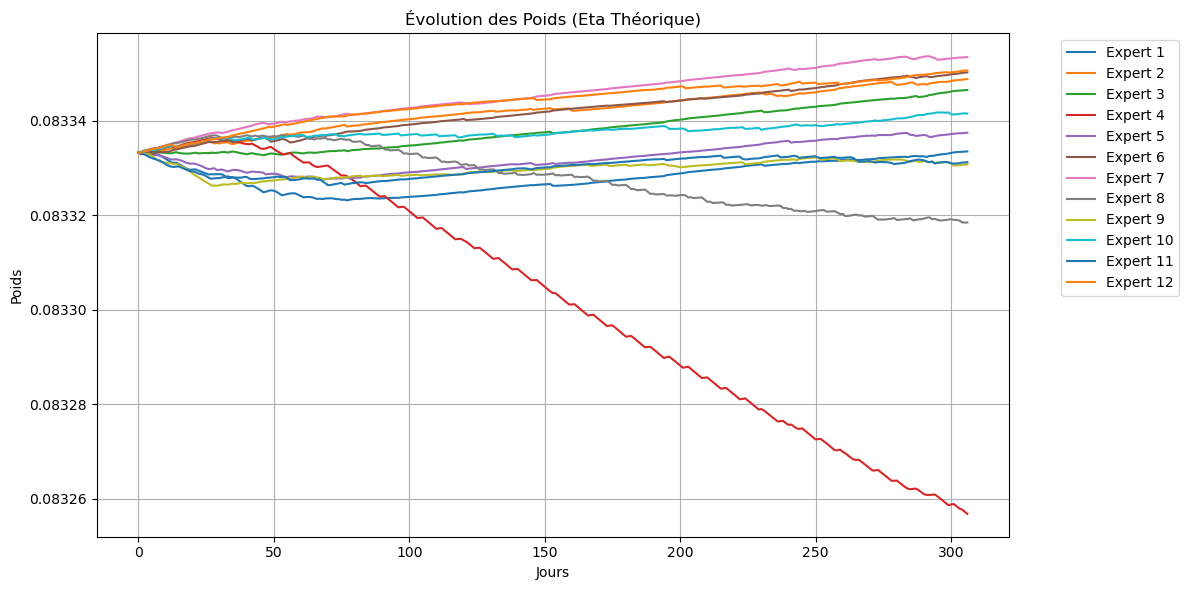

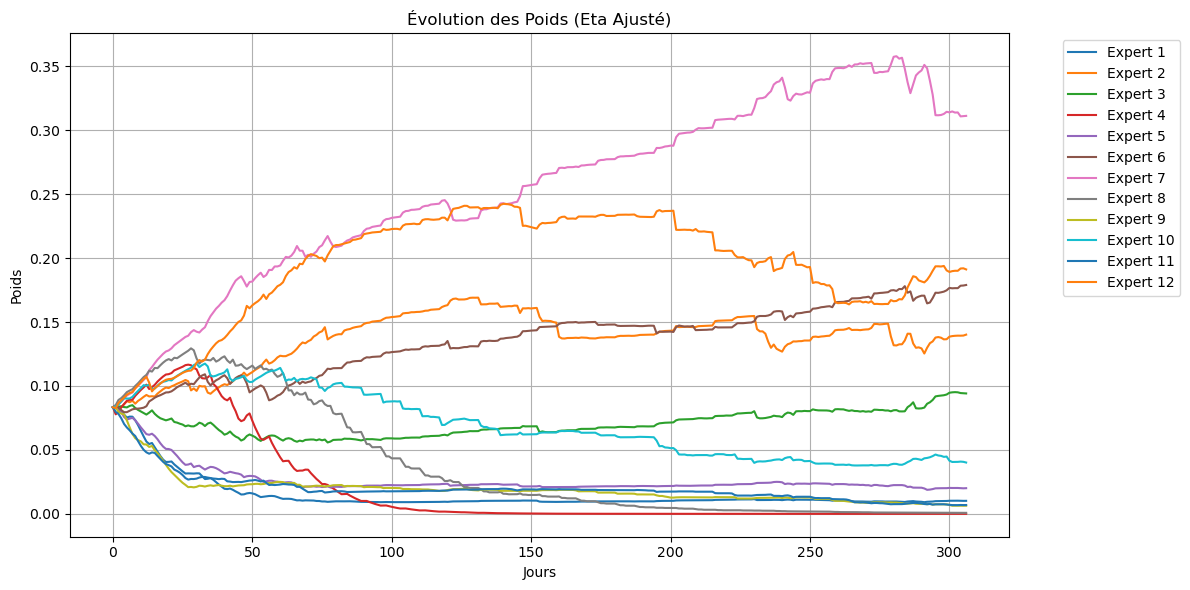

In [540]:
import numpy as np
import matplotlib.pyplot as plt

# Valeurs de eta
eta_tuned = best_eta_ewa  # Valeur ajustée manuellement

# Stocker les poids pour les deux valeurs de eta
weights_theoretical = np.zeros((T + 1, d))
weights_tuned = np.zeros((T + 1, d))
weights_theoretical[0, :] = 1/d
weights_tuned[0, :] = 1/d


# Mise à jour des poids pour les deux valeurs de eta
for day in range(T):
    # Calculer les pertes
    loss_experts = (experts.iloc[day, :] - targets.iloc[day]) ** 2  # Pertes quadratiques
    loss_experts /= np.max(loss_experts)
    # Mise à jour des poids pour eta théorique
    weights_theoretical[day + 1] = EWA_update(eta_theoretical_ewa, weights_theoretical[day], loss_experts)

    # Mise à jour des poids pour eta ajusté
    weights_tuned[day + 1] = EWA_update(eta_tuned, weights_tuned[day], loss_experts)

# Tracer l'évolution des poids pour eta théorique
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(weights_theoretical[:, i], label=f'Expert {i + 1}')
plt.title('Évolution des Poids (Eta Théorique)')
plt.xlabel('Jours')
plt.ylabel('Poids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Tracer l'évolution des poids pour eta ajusté
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(weights_tuned[:, i], label=f'Expert {i + 1}')
plt.title('Évolution des Poids (Eta Ajusté)')
plt.xlabel('Jours')
plt.ylabel('Poids')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

### Question 5 -- EG

Repeat questions 3 and 4 by using the gradient of the loss (i.e., by using EG) instead of the loss vectors of the experts directly. 

In [469]:
def EG_update(eta, weights, gradients):
    """
    Exponential Gradient (EG) update rule.
    
    Parameters:
    - eta: float, learning rate
    - weights: np.array of shape (M,), current weights (must sum to 1)
    - gradients: np.array of shape (M,), gradients of the loss for each expert
    
    Returns:
    - np.array of shape (M,), updated weights forming a probability distribution
    """
    # Appliquer l'exponentielle sur les gradients pondérés par eta
    exp_gradients = np.exp(-eta * gradients)
    # Mise à jour des poids
    new_weights = weights * exp_gradients
    # Normalisation pour former une distribution de probabilité
    return new_weights / np.sum(new_weights)

# Définir le taux d'apprentissage
eta = 1

# Initialiser les poids
p = np.zeros((T + 1, d))
p[0, :] = np.full(d, 1 / d)

# Initialiser les prédictions pondérées
pred = np.zeros(T)

# Calculer les prédictions et mettre à jour les poids
for day in range(T):
    # Prédiction pondérée
    pred[day] = np.dot(p[day, :], experts.iloc[day, :])
    
    # Calcul des gradients des pertes (dérivées)
    gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])
    
    # Mettre à jour les poids avec EG
    p[day + 1] = EG_update(eta, p[day], gradients)


def find_best_eta_eg(experts, targets, eta_values, T, d):

    best_eta = None
    best_loss = float('inf')  # Initialisé avec une perte très grande

    for eta in eta_values:
        # Initialiser les poids
        p = np.zeros((T + 1, d))
        p[0, :] = np.full(d, 1 / d)

        # Calculer les prédictions et les pertes
        for day in range(T):
            gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])  # Gradient des pertes
            # Normalisation des gradients 
            gradients /=np.max(gradients)
            p[day + 1] = EG_update(eta, p[day], gradients)

        # Calculer la perte moyenne finale
        predictions = np.dot(p[:T, :], experts.T)  # Prédictions pondérées
        loss = np.mean((predictions - targets.values) ** 2)  # Perte quadratique moyenne

        # Vérifier si cette perte est la meilleure
        if loss < best_loss:
            best_loss = loss
            best_eta = eta

    return best_eta, best_loss

# Paramètres
best_eta_eg, best_loss_eg = find_best_eta_eg(experts, targets, eta_values, T, d)

print(f"Meilleure valeur de eta pour EG : {best_eta_eg}")
print(f"Perte moyenne minimale pour EG : {best_loss_eg}")


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Meilleure valeur de eta pour EG : 0.001
Perte moyenne minimale pour EG : 1146498.9495410135


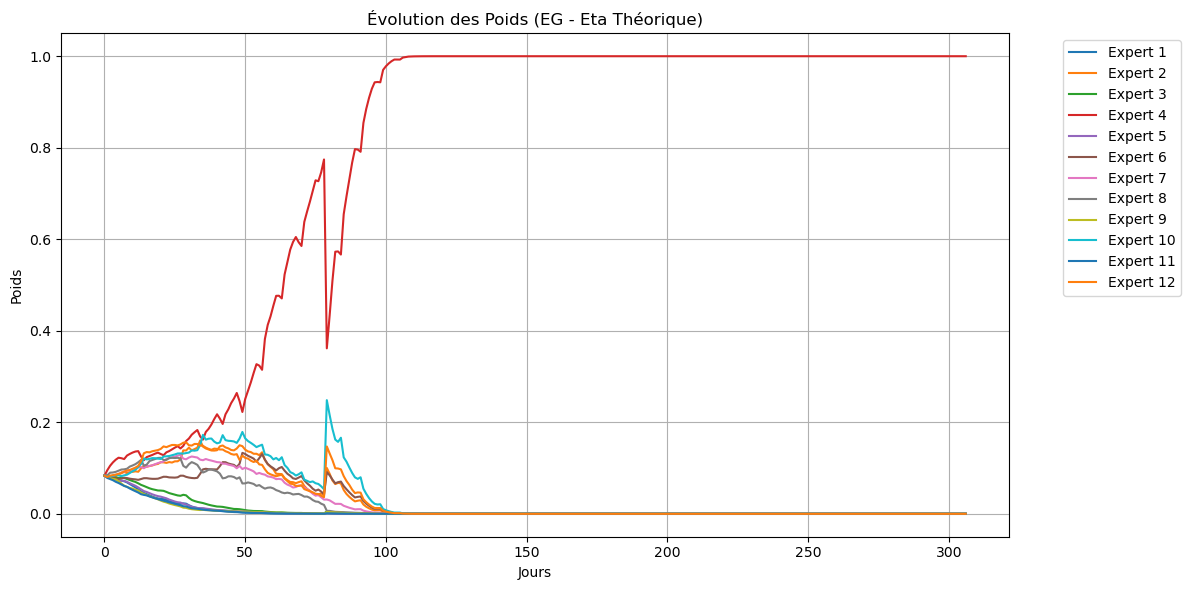

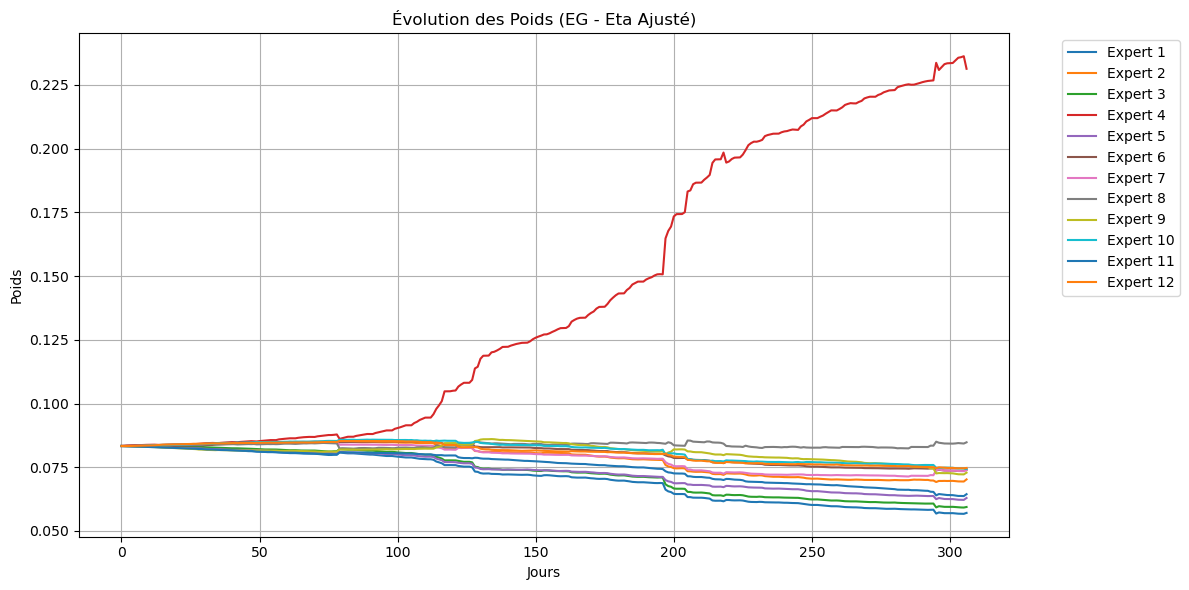

In [551]:
# Calcul de eta théorique pour EG
eta_theoretical_eg = np.sqrt(np.log(d) / T)
eta_tuned = best_eta_eg  # Valeur ajustée manuellement

# Initialiser les matrices de poids
weights_theoretical_EG = np.zeros((T + 1, d))
weights_tuned_EG = np.zeros((T + 1, d))
weights_theoretical_EG[0, :] = 1 / d
weights_tuned_EG[0, :] = 1 / d

# Mise à jour des poids pour chaque valeur de eta
for day in range(T):
    # Calcul des gradients des pertes
    gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])
    # Normalisation des gradients 
    gradients /=np.max(gradients)
    
    # Mise à jour des poids pour eta théorique
    weights_theoretical_EG[day + 1, :] = EG_update(eta_theoretical_eg, weights_theoretical_EG[day, :], gradients)
    
    # Mise à jour des poids pour eta ajusté
    weights_tuned_EG[day + 1, :] = EG_update(eta_tuned, weights_tuned_EG[day, :], gradients)

# Tracer l'évolution des poids pour eta théorique
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(weights_theoretical_EG[:, i], label=f'Expert {i + 1}')
plt.title("Évolution des Poids (EG - Eta Théorique)")
plt.xlabel("Jours")
plt.ylabel("Poids")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

# Tracer l'évolution des poids pour eta ajusté
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(weights_tuned_EG[:, i], label=f'Expert {i + 1}')
plt.title("Évolution des Poids (EG - Eta Ajusté)")
plt.xlabel("Jours")
plt.ylabel("Poids")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

### Question 6 - Projection on the unit simplex

Here is a simple algorithm to implement (Source at the end of the document).

Let $x=\big(x(i)\big)\in\mathbb{R}^M$,
- Sort the coordinates of x into $y_1\geq y_2\geq\dots\geq y_M$,
- Find
$$ \rho=\max\Big\{j\in 1,\dots,M:\ y_j-\frac{1}{j}\big(\sum_{r=1}^jy_r-1\big)>0\Big\},$$
- Define $z = \frac{1}{\rho}\big(\sum_{r=1}^jy_r-1\big)$,
- Return, for all $i=1, \dots,M$
$$\big(\Pi_{\Delta_M}(x)\big)(i) = \max\big\{x(i)-z, 0\big\}$$

Define the projection function.



In [554]:
import numpy as np

def proj_simplex(p):
    """
    Projects a vector p onto the unit simplex.
    
    Parameters:
    - p: np.array, vector in R^M
    
    Returns:
    - np.array, vector projected onto the unit simplex Delta_M
    """
    # Trier les coordonnées de p en ordre décroissant
    sorted_p = np.sort(p)[::-1]  # Tri décroissant
    cumsum = np.cumsum(sorted_p) - 1  # Cumul des sommes, soustrait 1
    rho = np.nonzero(sorted_p > cumsum / np.arange(1, len(p) + 1))[0][-1]  # Trouver rho
    theta = cumsum[rho] / (rho + 1)  # Calcul de theta
    projected = np.maximum(p - theta, 0)  # Appliquer max(x_i - theta, 0) pour chaque composante
    return projected


# Exemple d'utilisation
x = np.array([0.5, 0.3, 0.2])  
projection = proj_simplex(x)
print("Projection sur le simplexe : ", projection)

Projection sur le simplexe :  [0.5 0.3 0.2]


### Question 7 - OGD
Implement the update rule of the Online Gradient Descent algorithm, that take the current weight vector $p_t$, the gradientof $g_t$ and a learning rate and return the new weight vector.

In [557]:
def OGD_update(eta, p, g):
    
    # eta: learning rate
    # p: an np.array of shape (M,); vector of weights in Delta_M; to be updated
    # g: an np.array of shape (M,); gradient of the loss
    # Returns: an np.array of shape (M,); p updated with the loss l

    
    # Mise à jour des poids en soustrayant le gradient pondéré par eta
    updated_p = p - eta * g
    
    # Projeter les poids mis à jour sur le simplexe unité
    projected_p = proj_simplex(updated_p)
    
    return projected_p


# Exemple d'utilisation
eta = 0.01  # Taux d'apprentissage
p = np.array([0.5, 0.3, 0.2])  # Vecteur de poids actuel
g = np.array([0.1, 0.2, 0.1])  # Exemple de gradient

# Mise à jour du vecteur de poids
updated_p = OGD_update(eta, p, g)
print("Vecteur de poids mis à jour : ", updated_p)

Vecteur de poids mis à jour :  [0.50033333 0.29933333 0.20033333]


### Question 8 
Repeat questions 3 and 4 with OGD.

In [560]:
def find_best_eta_ogd(experts, targets, eta_values, T, d):
    """
    Trouve le meilleur eta pour OGD en minimisant la perte moyenne finale.
    
    Parameters:
    - experts: DataFrame, prédictions des experts
    - targets: Series, cibles réelles
    - eta_values: list, valeurs de eta à tester
    - T: int, nombre de jours
    - d: int, nombre d'experts
    
    Returns:
    - best_eta: float, meilleure valeur de eta
    - best_loss: float, perte moyenne pour le meilleur eta
    """
    best_eta = None
    best_loss = float('inf')  # Initialiser avec une perte très grande

    for eta in eta_values:
        # Initialiser les poids
        p = np.zeros((T + 1, d))
        p[0, :] = np.full(d, 1 / d)  # Distribution uniforme initiale

        # Calculer les prédictions et les pertes
        for day in range(T):
            gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])  # Gradient des pertes
            # Normalisation des gradients 
            gradients /=np.max(gradients)
            p[day + 1, :] = OGD_update(eta, p[day, :], gradients)  # Mise à jour OGD

        # Calculer la perte moyenne finale
        predictions = np.dot(p[:T, :], experts.T)  # Prédictions pondérées
        loss = np.mean((predictions - targets.values) ** 2)  # Perte quadratique moyenne

        # Vérifier si cette perte est la meilleure
        if loss < best_loss:
            best_loss = loss
            best_eta = eta

    return best_eta, best_loss

# Paramètres
eta_values = np.linspace(0.001, 1, 100)  # Plage de valeurs pour eta
best_eta_ogd, best_loss_ogd = find_best_eta_ogd(experts, targets, eta_values, T, d)

print(f"Meilleure valeur de eta ajusté pour OGD : {best_eta_ogd}")
print(f"Perte moyenne minimale pour OGD : {best_loss_ogd}")


Meilleure valeur de eta pour OGD : 0.001
Perte moyenne minimale pour OGD : 6722551.128518899


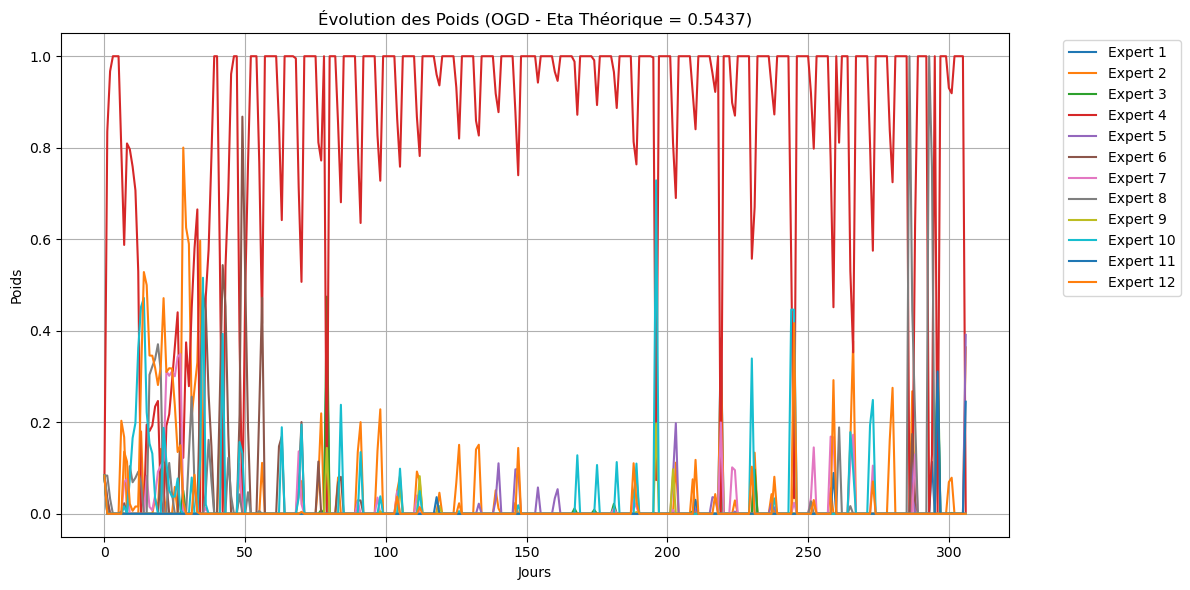

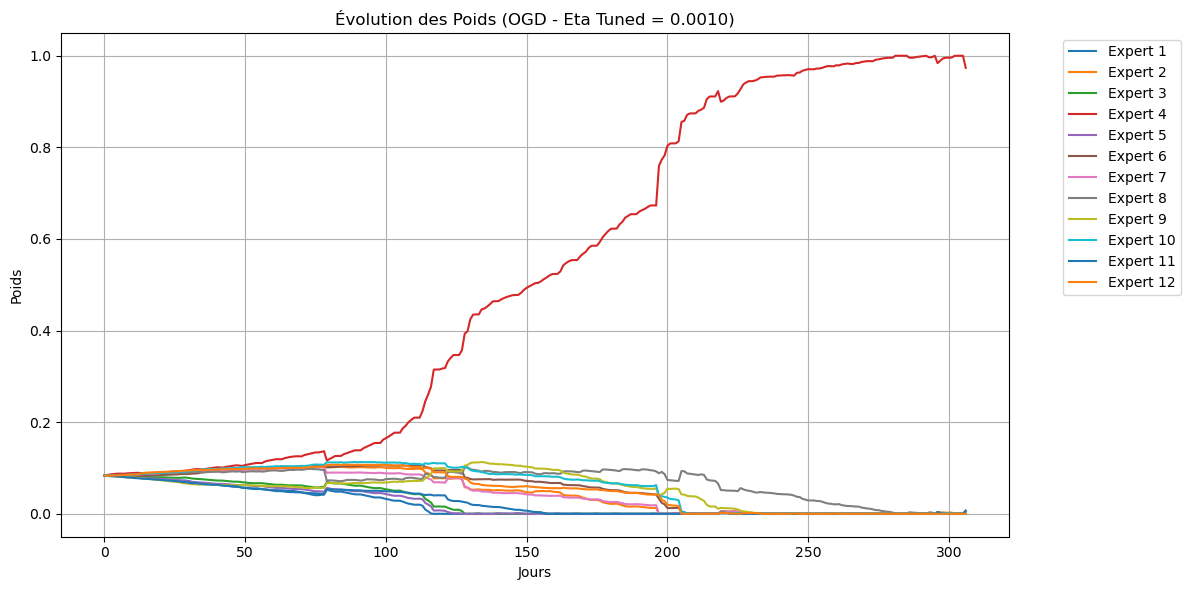

In [561]:
# Calcul de eta théorique
gradient = 2 * (experts.values - targets.values[:, None])  # Gradients pour chaque expert
G = np.max(np.abs(gradient))  # Borne maximale
D = np.max(np.linalg.norm(experts.values[:, None, :] - experts.values[None, :, :], axis=-1))
D / (G * np.sqrt(T))

eta_theoretical_OGD = D / (G * np.sqrt(T))  # Taux d'apprentissage théorique

#eta ajusté
eta_tuned = best_eta_ogd  # Taux d'apprentissage ajusté (trouvé auparavant)

# Initialiser les poids pour les deux cas
p_theoretical = np.zeros((T + 1, d))
p_tuned = np.zeros((T + 1, d))
p_theoretical[0, :] = np.full(d, 1 / d)  # Distribution uniforme initiale
p_tuned[0, :] = np.full(d, 1 / d)  # Distribution uniforme initiale

# Initialiser les prédictions pondérées
pred_theoretical = np.zeros(T)
pred_tuned = np.zeros(T)

# Calculer les prédictions et mettre à jour les poids avec OGD
for day in range(T):
    # Prédiction pondérée pour eta théorique
    pred_theoretical[day] = np.dot(p_theoretical[day, :], experts.iloc[day, :])
    
    # Calcul des gradients des pertes
    gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])
    gradients /= np.max(gradients)  # Normalisation des gradients (facultative)
    
    # Mise à jour des poids avec eta théorique
    p_theoretical[day + 1, :] = OGD_update(eta_theoretical, p_theoretical[day, :], gradients)
    
    # Prédiction pondérée pour eta ajusté
    pred_tuned[day] = np.dot(p_tuned[day, :], experts.iloc[day, :])
    
    # Mise à jour des poids avec eta ajusté
    p_tuned[day + 1, :] = OGD_update(eta_tuned, p_tuned[day, :], gradients)

# Tracer l'évolution des poids pour eta théorique
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(p_theoretical[:, i], label=f'Expert {i + 1}')
plt.title(f"Évolution des Poids (OGD - Eta Théorique = {eta_theoretical:.4f})")
plt.xlabel("Jours")
plt.ylabel("Poids")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

# Tracer l'évolution des poids pour eta ajusté
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(p_tuned[:, i], label=f'Expert {i + 1}')
plt.title(f"Évolution des Poids (OGD - Eta Tuned = {eta_tuned:.4f})")
plt.xlabel("Jours")
plt.ylabel("Poids")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()

### Question 9
Print a table summarizing the average losses suffered by the best expert, the best fixed combination of experts, EWA, EG, and OGD (each for the best learning rate tuned on data and the theoretical value).


In [565]:
# Calculer les prédictions et les pertes moyennes pour EWA (eta théorique)
pred_ewa_theoretical = np.zeros(T)
for day in range(T):
    pred_ewa_theoretical[day] = np.dot(weights_theoretical[day, :], experts.iloc[day, :])
ewa_theoretical_loss = np.mean((pred_ewa_theoretical - targets.values) ** 2)

# Calculer les prédictions et les pertes moyennes pour EWA (eta ajusté)
pred_ewa_tuned = np.zeros(T)
for day in range(T):
    pred_ewa_tuned[day] = np.dot(weights_tuned[day, :], experts.iloc[day, :])
ewa_tuned_loss = np.mean((pred_ewa_tuned - targets.values) ** 2)


# Calculer les prédictions et les pertes moyennes pour EG (eta théorique)
pred_eg_theoretical = np.zeros(T)
for day in range(T):
    pred_eg_theoretical[day] = np.dot(weights_theoretical_EG[day, :], experts.iloc[day, :])
eg_theoretical_loss = np.mean((pred_eg_theoretical - targets.values) ** 2)

# Calculer les prédictions et les pertes moyennes pour EG (eta ajusté)
pred_eg_tuned = np.zeros(T)
for day in range(T):
    pred_eg_tuned[day] = np.dot(weights_tuned_EG[day, :], experts.iloc[day, :])
eg_tuned_loss = np.mean((pred_eg_tuned - targets.values) ** 2)

# Calculer les pertes moyennes pour OGD (eta théorique)
ogd_theoretical_loss = np.mean((pred_theoretical - targets.values) ** 2)

# Calculer les pertes moyennes pour OGD (eta ajusté)
ogd_tuned_loss = np.mean((pred_tuned - targets.values) ** 2)


# Calculer la perte moyenne pour le meilleur expert
# Calculer les pertes pour chaque expert
expert_losses = []
for i in range(d):
    expert_loss = np.mean((experts.iloc[:, i] - targets.values) ** 2)
    expert_losses.append(expert_loss)
best_expert_loss = np.min(expert_losses)  # Meilleur expert

# Calculer la perte moyenne pour la meilleure combinaison fixe d'experts
# Utiliser la régression linéaire pour minimiser la perte quadratique
fixed_combination_weights = np.linalg.lstsq(experts.values, targets.values, rcond=None)[0]
fixed_combination_predictions = experts.dot(fixed_combination_weights)
fixed_combination_loss = np.mean((fixed_combination_predictions - targets.values) ** 2)

# Résumer les résultats dans une table
results = {
    "Method": [
        "Best Expert",
        "Best Fixed Combination",
        "EWA (eta_theoretical)",
        "EWA (eta_tuned)",
        "EG (eta_theoretical)",
        "EG (eta_tuned)",
        "OGD (eta_theoretical)",
        "OGD (eta_tuned)"
    ],
    "Average Loss": [
        best_expert_loss,
        fixed_combination_loss,
        ewa_theoretical_loss,
        ewa_tuned_loss,
        eg_theoretical_loss,
        eg_tuned_loss,
        ogd_theoretical_loss,
        ogd_tuned_loss
    ]
}

# Créer un DataFrame Pandas pour afficher les résultats
results_table = pd.DataFrame(results)

# Afficher la table
print("Résultats des pertes moyennes par méthode :")
print(results_table)

# Optionnel : Exporter la table en fichier CSV
results_table.to_csv("average_losses_results.csv", index=False)



Résultats des pertes moyennes par méthode :
                   Method  Average Loss
0             Best Expert  1.121471e+06
1  Best Fixed Combination  6.666515e+05
2   EWA (eta_theoretical)  1.043545e+06
3         EWA (eta_tuned)  9.664542e+05
4    EG (eta_theoretical)  1.408471e+07
5          EG (eta_tuned)  1.252355e+06
6   OGD (eta_theoretical)  1.245620e+07
7         OGD (eta_tuned)  8.127460e+06


### Question 10 (optional)
Test better solutions to tune the learning rate in practice. Ideas: use $\eta_t = \sqrt{1/\sum_{s=1}^t \|g_s\|^2}$ for OGD, where $g_s$ is the gradient at time $s$, or define a grid of possible learning rate and use at time $t$ the learning rate that performed the best until round $t-1$.

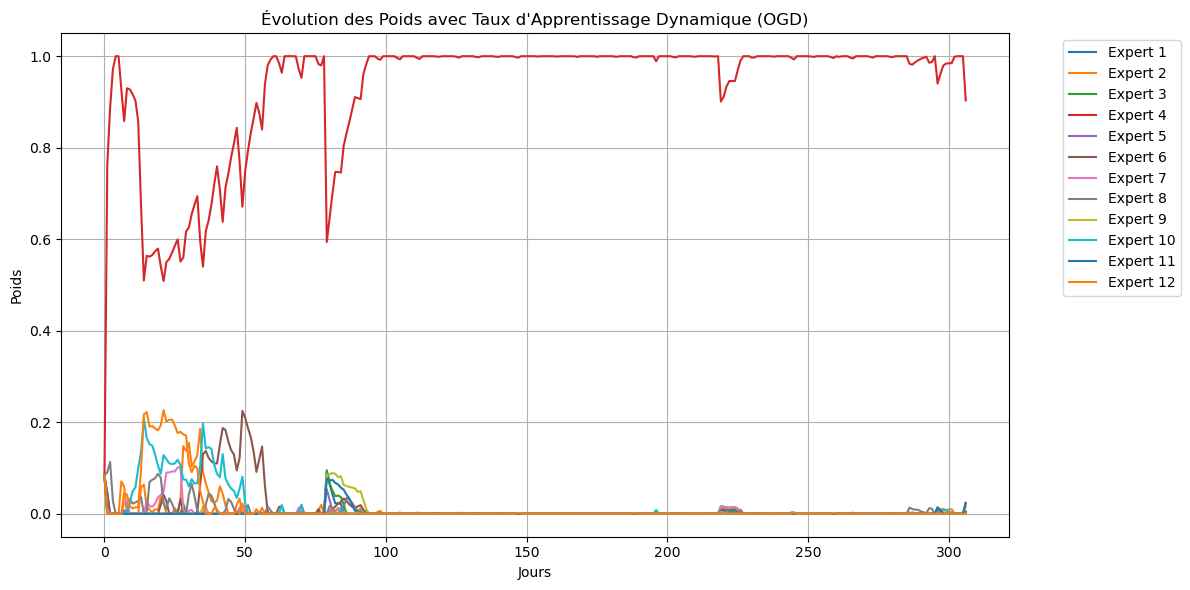

In [568]:
import numpy as np
import matplotlib.pyplot as plt

# Initialiser les poids pour OGD
p_dynamic = np.zeros((T + 1, d))
p_dynamic[0, :] = np.full(d, 1 / d)  # Distribution uniforme initiale

# Initialiser les prédictions pondérées et les gradients cumulés
pred_dynamic = np.zeros(T)
gradient_norm_squared_sum = 0  # \(\sum_{s=1}^t \|g_s\|^2\)

# Calculer les prédictions et ajuster eta dynamiquement
for day in range(T):
    # Prédiction pondérée
    pred_dynamic[day] = np.dot(p_dynamic[day, :], experts.iloc[day, :])
    
    # Calculer les gradients des pertes
    gradients = 2 * (experts.iloc[day, :] - targets.iloc[day])
    # Normalisation des gradients 
    gradients /=np.max(gradients)
    
    # Mettre à jour la somme des normes au carré des gradients
    gradient_norm_squared_sum += np.sum(gradients**2)
    
    # Calculer le taux d'apprentissage dynamique
    eta_dynamic = np.sqrt(1 / gradient_norm_squared_sum)
    
    # Mise à jour des poids avec OGD
    p_dynamic[day + 1, :] = OGD_update(eta_dynamic, p_dynamic[day, :], gradients)

# Tracer l'évolution des poids
plt.figure(figsize=(12, 6))
for i in range(d):
    plt.plot(p_dynamic[:, i], label=f'Expert {i + 1}')
plt.title("Évolution des Poids avec Taux d'Apprentissage Dynamique (OGD)")
plt.xlabel("Jours")
plt.ylabel("Poids")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.tight_layout()
plt.show()


### Question 11 (optional)
Repeat questions 3 and 4 with ONS or AdaGrad. 



### Question 12 (optional)
Build your own forecasting models using data_train based on machine learning models or statistical methods and combine them to see if you improve their performance.


# References
- Duchi, J., Shalev-Shwartz, S., Singer, Y., & Chandra, T. (2008, July). Efficient projections onto the l 1-ball for learning in high dimensions. In Proceedings of the 25th international conference on Machine learning (pp. 272-279).